Gradient Boosting model with engineered features and scaling

Categorical columns: ['Sex', 'Embarked', 'Title']
Numeric columns: ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'AgeMissing']


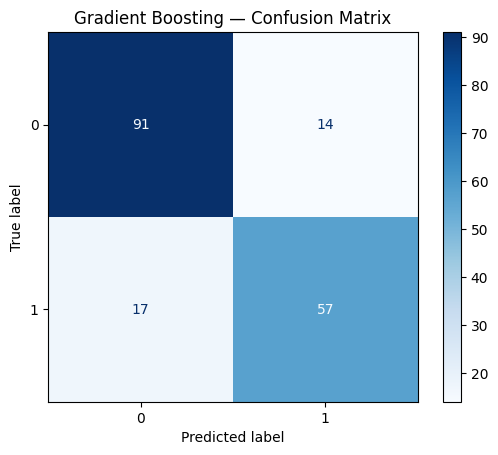

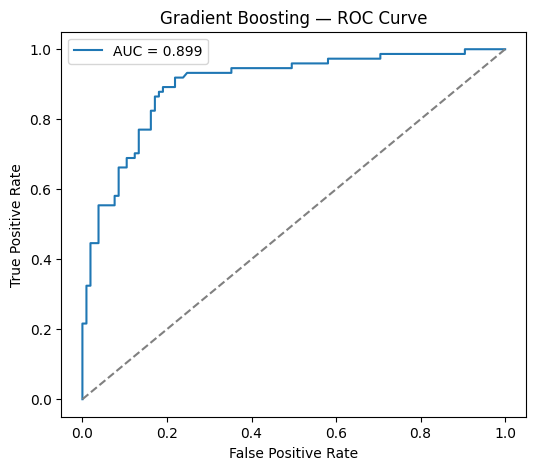

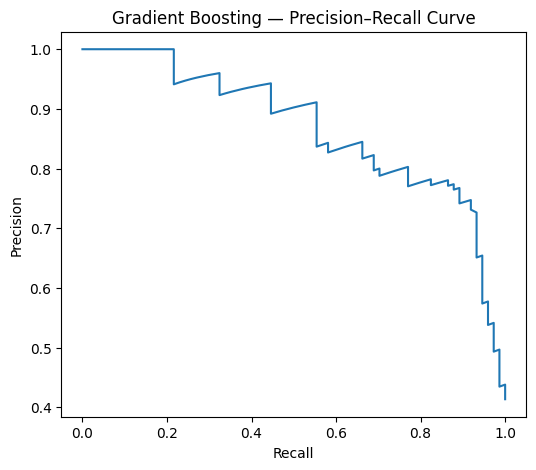

Ready for Kaggle: ../submissions/submission_gb_engineered_scaling.csv


In [1]:
# ============================================================
# Gradient Boosting Model Using Engineered Features + OHE + Scaling
# ============================================================

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    roc_auc_score,
    precision_recall_curve
)
import json
import numpy as np

# ============================================================
# 1. Load processed datasets
# ============================================================

train = pd.read_csv("../data/processed_v2/train_features.csv")
test = pd.read_csv("../data/processed_v2/test_features.csv")

test_passenger_ids = test["PassengerId"]

# ============================================================
# 2. Identify feature columns
# ============================================================

y = train["Survived"]
X = train.drop(columns=["Survived", "PassengerId"])
X_test_final = test.drop(columns=["PassengerId"])

# ============================================================
# 3. Load categorical metadata
# ============================================================

with open("../data/processed_v2/processed_metadata.json", "r") as f:
    meta = json.load(f)

categorical_cols = list(meta.keys())
numeric_cols = [col for col in X.columns if col not in categorical_cols]

print("Categorical columns:", categorical_cols)
print("Numeric columns:", numeric_cols)

# ============================================================
# 4. Preprocessing: OHE + Scaling
# ============================================================

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ("num", StandardScaler(), numeric_cols),
    ]
)

# ============================================================
# 5. Build Gradient Boosting pipeline
# ============================================================

gb_model = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("gb", GradientBoostingClassifier(
            n_estimators=300,
            learning_rate=0.05,
            max_depth=3,
            random_state=42
        ))
    ]
)

# ============================================================
# 6. Train-validation split
# ============================================================

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ============================================================
# 7. Train model
# ============================================================

gb_model.fit(X_train, y_train)

y_pred = gb_model.predict(X_val)
y_proba = gb_model.predict_proba(X_val)[:, 1]

# ============================================================
# 8. Confusion Matrix
# ============================================================

cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Gradient Boosting — Confusion Matrix")
plt.show()

# ============================================================
# 9. ROC Curve
# ============================================================

fpr, tpr, _ = roc_curve(y_val, y_proba)
auc = roc_auc_score(y_val, y_proba)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], "--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Gradient Boosting — ROC Curve")
plt.legend()
plt.show()

# ============================================================
# 10. Precision–Recall Curve
# ============================================================

precision, recall, _ = precision_recall_curve(y_val, y_proba)

plt.figure(figsize=(6, 5))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Gradient Boosting — Precision–Recall Curve")
plt.show()

# ============================================================
# 11. Train final model & create submission
# ============================================================

gb_model.fit(X, y)
test_proba = gb_model.predict_proba(X_test_final)[:, 1]
test_predictions = (test_proba >= 0.5).astype(int)  # default threshold

submission = pd.DataFrame({
    "PassengerId": test_passenger_ids,
    "Survived": test_predictions
})

submission_path = "../submissions/submission_gb_engineered_scaling.csv"
submission.to_csv(submission_path, index=False)
print(f"Ready for Kaggle: {submission_path}")